# Tutorial 1: Working with OpenStreetMap

Within this tutorial, we will explore the power of OpenStreetMap. We will learn how to extract information from OpenStreetMap, how you can explore and visualize this, and how to use it for some basic analysis.

### Important before we start
---
Make sure that you save this file before you continue, else you will lose everything. To do so, go to **Bestand/File** and click on **Een kopie opslaan in Drive/Save a Copy on Drive**!

Now, rename the file into Week4_Tutorial1.ipynb. You can do so by clicking on the name in the top of this screen.

## Learning Objectives
<hr>

- To understand the use of **OSMnx** to extract geospatial data from OpenStreetmap.
- To know how to rasterize vector data through using **Geocube**.
- To know how to visualise vector and raster data.
- To understand the basic functioning of **Matplotlib** to create a map.
- To know how one can generate routes between two points using **NetworkX**.
- To visualize networks on an interactive map.

<h2>Tutorial Outline<span class="tocSkip"></span></h2>
<hr>
<div class="toc"><ul class="toc-item">
<li><span><a href="#1.-Introducing the packages" data-toc-modified-id="1.-Introducing-the-packages-2">1. Introducing the packages</a></span></li>
<li><span><a href="#2.-Extracting land-use information from OpenStreetMap" data-toc-modified-id="2.-Extracting-landuse-information-3">2. Extract and visualize land-use information from OpenStreetMap</a></span></li>
<li><span><a href="#3.-Visualize and rasterize land-use information" data-toc-modified-id="3.-Visualize-Rasterize-4">3. Rasterize land-use information</a></span></li>
<li><span><a href="#4.-Extracting buildings from OpenStreetMap" data-toc-modified-id="4.-Extracting-buildings-5">4. Extracting buildings from OpenStreetMap</a></span></li>
<li><span><a href="#5.-Analyze and visualize building stock" data-toc-modified-id="5.-Analyze-buildings-6">5. Analyze and visualize building stock</a></span></li>
<li><span><a href="#6.-Extracting roads from OpenStreetMap" data-toc-modified-id="4.-Extracting-roads-5">6. Extracting roads from OpenStreetMap</a></span></li>
<li><span><a href="#7.-Plot Routes Using OpenStreetMap and Folium" data-toc-modified-id="5.-Plot-routes-6">7. Plot Routes Using OpenStreetMap and Folium</a></span></li></ul></div>

## 1.Introducing the packages
<hr>

Within this tutorial, we are going to make use of the following packages: 

[**GeoPandas**](https://geopandas.org/) is a Python packagee that extends the datatypes used by pandas to allow spatial operations on geometric types.

[**OSMnx**](https://osmnx.readthedocs.io/) is a Python package that lets you download geospatial data from OpenStreetMap and model, project, visualize, and analyze real-world street networks and any other geospatial geometries. You can download and model walkable, drivable, or bikeable urban networks with a single line of Python code then easily analyze and visualize them. You can just as easily download and work with other infrastructure types, amenities/points of interest, building footprints, elevation data, street bearings/orientations, and speed/travel time.

[**NetworkX**](https://networkx.org/) is a Python package for the creation, manipulation, and study of the structure, dynamics, and functions of complex networks.

[**Matplotlib**](https://matplotlib.org/) is a comprehensive Python package for creating static, animated, and interactive visualizations in Python. Matplotlib makes easy things easy and hard things possible.

[**Geocube**](https://corteva.github.io/geocube) is a Python package to convert geopandas vector data into rasterized data.

[**xarray**](https://docs.xarray.dev/) is a Python package that allows for easy and efficient use of multi-dimensional arrays.

*We will first need to install these packages in the cell below. Uncomment them to make sure we can pip install them*

In [1]:
#!pip install osmnx
#!pip install geopandas
#!pip install geocube
#!pip install contextily

As you may or may not have seen while installing, there was a warning that we need to restart our runtime. To do so, click on **Runtime** in the topbar menu and click on **Runtime opnieuw starten**/**Restart runtime**.

Now we will import these packages in the cell below:

In [2]:
import osmnx as ox
import numpy as np
import networkx as nx
import contextily as cx
import matplotlib

import geopandas as gpd

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from IPython.display import IFrame
from geocube.api.core import make_geocube

%matplotlib inline

## 2. Extract and visualize land-use information from OpenStreetMap
<hr>

The first step is to define which area you want to focus on. In the cell below, you will now read "Steenwijk, The Netherlands". Change this to any random or municipality in the Netherlands that (1) you can think of and (2) will work. 

In some cases, the function does not recognize the location. You could either try a different phrasing or try a different location. Many parts of the Netherlands should work.

In [3]:
place_name = "Zoeterwoude, The Netherlands"
area = ox.geocode_to_gdf(place_name)

Now let us visualize the bounding box of the area. As you will notice, we also estimate the size of the area. If the area size is above 50km2, or when you have many elements within your area (for example the amsterdam city centre), extracting the data from OpenStreetMap may take a little while. 

Text(0.5, 1.0, 'Zoeterwoude, The Netherlands. Total area: 51 km2')

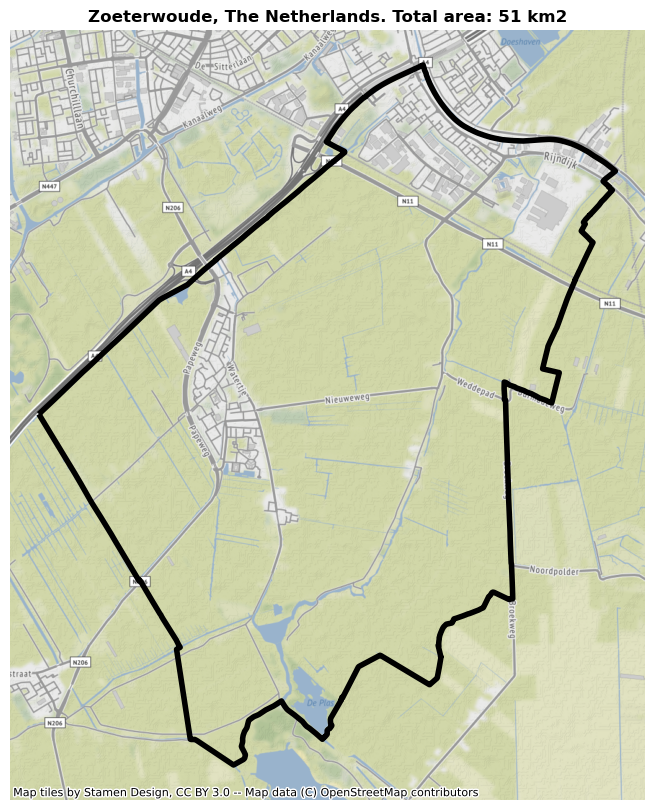

In [4]:
area_to_check = area.to_crs(epsg=3857)
ax = area_to_check.plot(figsize=(10, 10), color="none", edgecolor="k", linewidth=4)
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()
cx.add_basemap(ax, zoom=14)

size = int(area_to_check.area/1e6)

ax.set_title("{}. Total area: {} km2".format(place_name,size),fontweight='bold')

Now we are satisfied with the selected area, we are going to extract the land-use information from OpenStreetMap. To find the right information from OpenStreetMap, we use **tags**.

As you will see in the cell below, we use the tags *"landuse"* and *"natural"*. We need to use the *"natural"* tag to ensure we also obtain water bodies and other natural elements. 

In [5]:
tags = {'landuse': True, 'natural': True}   
landuse = ox.geometries_from_place(place_name, tags)

To ensure we really only get the area that we want, we use geopandas's `clip` function to only keep the area we want. This function does exactly the same as the `clip` function in QGIS.

In [6]:
landuse = landuse.clip(area)

When we want to visualize or analyse the data, we want all information in a single column. However, at the moment, all information that was tagged as *"natural"*, has no information stored in the *"landuse"* tags. It is, however, very convenient if we can just use a single column for further exploration of the data. 

To overcome this issue, we need to add the missing information to the landuse column, as done below.

In [7]:
landuse.loc[landuse.natural=='water','landuse'] = 'water'
landuse.loc[landuse.natural=='beach','landuse'] = 'beach'
landuse.loc[landuse.natural=='grassland','landuse'] = 'grass'
landuse.loc[landuse.natural=='wetland','landuse'] = 'wetlands'
landuse = landuse.dropna(subset=['landuse'])

Our next step is to prepare the visualisation of a map. What better way to explore land-use information than plotting it on a map? 

As you will see below, we can create a dictionary with color codes that will color each land-use class based on the color code provided in this dictionary.

In [8]:
color_dict = {  "grass":'#c3eead',               "railway": "#000000",
                "forest":'#1c7426',              "orchard":'#fe6729',
                "residential":'#f13013',         "industrial":'#0f045c',
                "retail":'#b71456',              "education":'#d61181',              
                "commercial":'#981cb8',          "farmland":'#fcfcb9',
                "cemetery":'#c39797',            "construction":'#c0c0c0',
                "meadow":'#c3eead',              "farmyard":'#fcfcb9',
                "plant_nursery":'#eaffe2',       "scrub":'#98574d',
                "allotments":'#fbffe2',          "reservoir":'#8af4f2',
                "static_caravan":'#ff3a55',      "wetlands": "#c9f5e5",
                "water": "#c9e5f5",              "beach": "#ffeead",
                "landfill" : "#B08C4D",          "recreation_ground" : "#c3eead",
                "brownfield" : "#B08C4D",        "village_green" : "#f13013" ,
                "military": "#52514E",            "garden" : '#c3eead'
             } 

Unfortunately, OpenSteetMap very often contains elements that have a unique tag. As such, it may be the case that some of our land-use categories are not in the dictionary yet. 

Let's first create an overview of the unique land-use categories within our data through using the `.unique()` function within our dataframe:

In [9]:
landuse.landuse.unique()

array(['water', 'forest', 'meadow', 'grass', 'farmyard', 'wetlands',
       'residential', 'industrial', 'farmland', 'cemetery',
       'construction', 'education', 'retail', 'plant_nursery', 'orchard',
       'allotments', 'railway'], dtype=object)

Ofcourse we can visually compare the array above with our color_dict, but it is much quicker to use `Sets` to check if there is anything missing:

In [10]:
set(landuse.landuse.unique())-set(color_dict)

set()

In case anything is missing, add them to the color_dict dictionairy and re-run that cell. 

```{tip}
You can find easily find hexcodes online to find the right colour for each land-use category. Just google hexcodes!
```


Our next step is to make sure that we can connect our color codes to our dataframe with land-use categories.

In [11]:
color_dict = {key: color_dict[key]
             for key in color_dict if key not in  list(set(color_dict)-set(landuse.landuse.unique()))}

map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))

landuse['col_landuse'] = landuse.landuse.apply(lambda x: color_dict[x])

Now we can plot the figure!

As you will see in the cell below, we first state that we want to create a figure with a specific figure size. You can change the dimensions to your liking.

Text(0.5, 1.0, 'Zoeterwoude, The Netherlands')

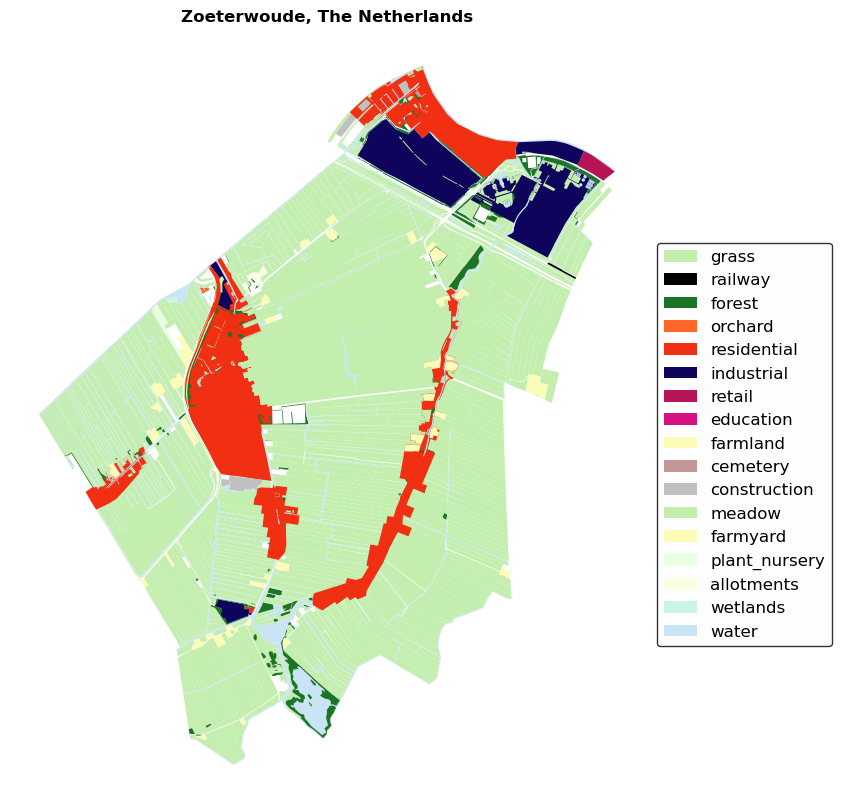

In [12]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)  

# and plot the land-use map.
landuse.plot(color=landuse['col_landuse'],ax=ax,linewidth=0)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))        

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2)) 

# add a title
ax.set_title(place_name,fontweight='bold')

## 3. Rasterize land-use information
<hr>

As you have noticed already during the lecture, and as we will again see next week when using the Google Earth Engine, most land-use data is in raster format. 

In OpenStreetMap everything is stored in vector format. As such, the land-use information we extracted from OpenStreetMap is also in vector format. While it is not always necessary to have this information in raster format, it is useful to know how to convert your data into a raster format.

To do so, we can make use of the **GeoCube** package, which is a newly developed Python package that can very easily convert vector data into a raster format.

The first thing we will need to do is to define all the unique land-use classes and store them in a dictionary:

In [13]:
categorical_enums = {'landuse': landuse.landuse.drop_duplicates().values.tolist()
}

And now we simply use the `make_geocube()` function to convert our vector data into raster data. 

In the `make_geocube()` function, we have to specify several arguments:

- Through the `vector_data` argument we have to state which dataframe we want to rasterize.
- Through the `output_crs` argument we have to state the coordinate reference system (CRS). We use the OpenStreetMap default EPSG:4326.
- Through the `resolution` argument we have to state the resolution. In our case, we will have to set this in degrees. 0.01 degrees is equivalent to roughly 10km around the equator. 
- Through the `categorical_enums` argument we specify the different land-use categories.

Play around with the different resolutions to find the level of detail. The higher the resolution (i.e., the more zeros behind the comma), the longer it will take to rasterize.

In [14]:
landuse_grid = make_geocube(
    vector_data=landuse,
    output_crs="epsg:4326",
    resolution=(-0.0001, 0.0001),
    categorical_enums=categorical_enums
)

Let's explore what this function has given us:

In [15]:
landuse_grid["landuse"]

<xarray.DataArray 'landuse' (y: 597, x: 800)>
array([[-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       ...,
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1],
       [-1, -1, -1, ..., -1, -1, -1]], dtype=int16)
Coordinates:
  * y            (y) float64 52.15 52.15 52.15 52.15 ... 52.09 52.09 52.09 52.09
  * x            (x) float64 4.471 4.471 4.471 4.471 ... 4.55 4.551 4.551 4.551
    spatial_ref  int32 0
Attributes:
    name:                 landuse
    long_name:            landuse
    _FillValue:           -1
    categorical_mapping:  landuse_categories

The output above is a typical output of the **xarray** package. 

- The `array` shows the numpy array with the actual values. As you can see, the rasterization process has used the value `-1` for NoData. 
- The `Coordinates` table shows the x (longitude) and y (latitude) coordinates of the array. It has the exact same size as the `array` with land-use values.
- The `Attributes` table specifies the NoData value (the `_FillValue` element, which indeed shows `-1`) and the name of the dataset.

Now let's plot the data to see the result!

Text(0.5, 1.0, 'Rasterized land-use map for Zoeterwoude, The Netherlands')

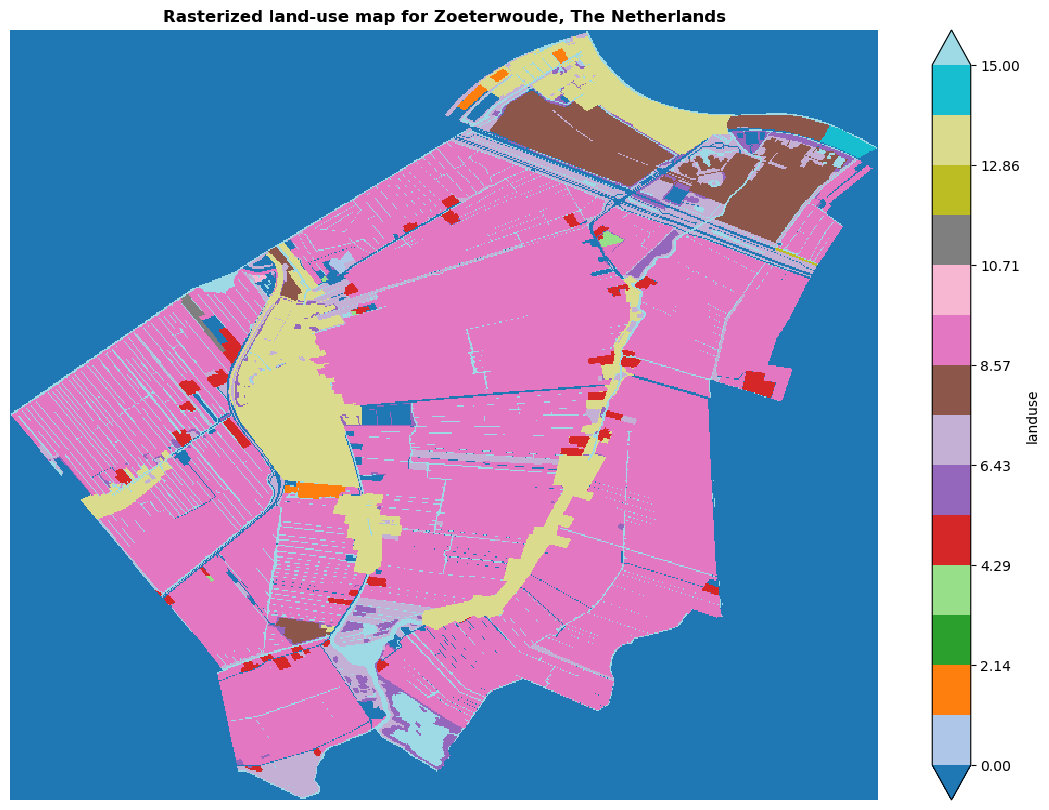

In [16]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_grid["landuse"].plot(ax=ax,vmin=0,vmax=15,levels=15,cmap='tab20')

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

ax.set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

As we can see in the figure above, the land-use categories have turned into numbers, instead of land-use categories described by a string value. 

This is of course a lot harder to interpret. Let's re-do some parts to make sure we can properly link them back to the original data.

To do so, we will first need to make sure that we know which values (numbers) are connected to each land-use category. Instead of trying to match, let's predefine this ourselves!

We will start with creating a dictionary that allows us to couple a number to each category:

In [17]:
value_dict = dict(zip(landuse.landuse.unique(),np.arange(0,len(landuse.landuse.unique()),1)))

In [18]:
value_dict['nodata'] = -1

And we now use this dictionary to add a new column to the dataframe with the values:

In [19]:
landuse['landuse_value'] = landuse.landuse.apply(lambda x: value_dict[x])

Now let us use the `make_geocube()` function again to rasterize.

In [20]:
landuse_valued = make_geocube(
    vector_data=landuse,
    output_crs="epsg:4326",
    resolution=(-0.0001, 0.0001),
    categorical_enums={'landuse_value': landuse.landuse_value.drop_duplicates().values.tolist()
}
)

And let's use the original `color_dict` dictionary to find the right hex codes for each of the land-use categories

In [21]:
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes] 

To plot the new result:

Text(0.5, 1.0, 'Rasterized land-use map for Zoeterwoude, The Netherlands')

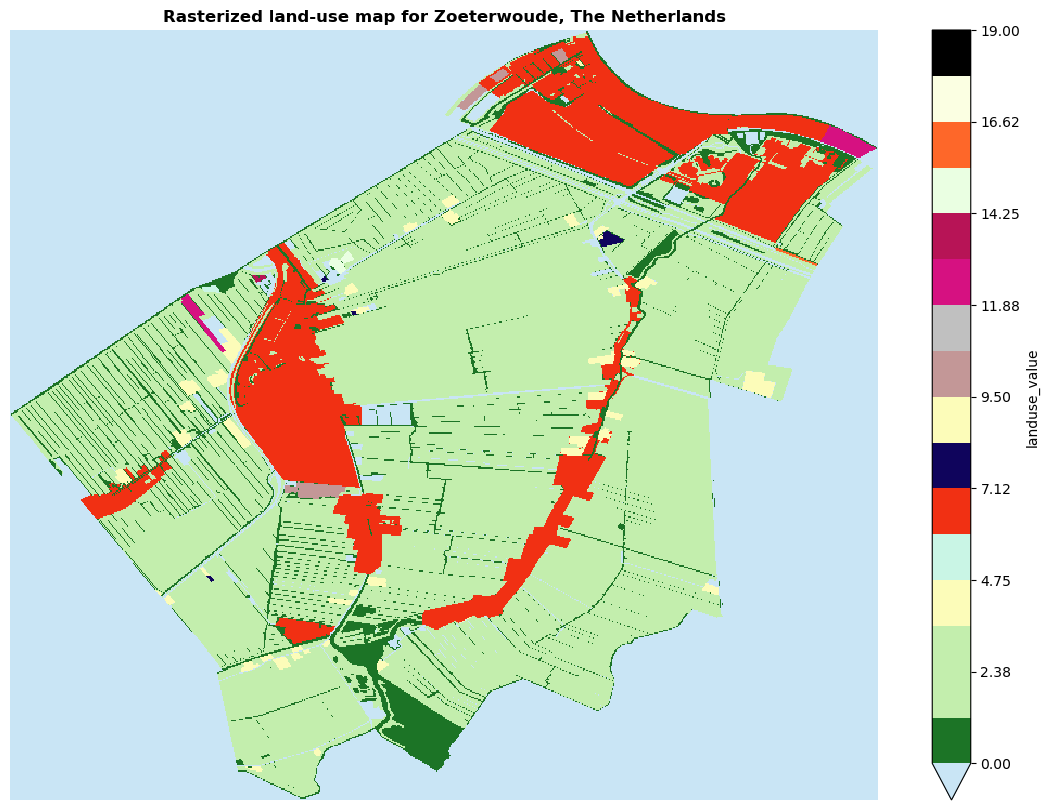

In [22]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

landuse_valued["landuse_value"].plot(ax=ax,vmin=0,vmax=19,levels=len(unique_classes),colors=colormap_raster)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

ax.set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

But to be honest, this legend is still not entirely what we are looking for. So let's do some Python magic to get a legend like we desire when plotting a land-use map

In [23]:
unique_classes = landuse.landuse.drop_duplicates().values.tolist()
colormap_raster = [color_dict[lu_class] for lu_class in unique_classes] 
color_dict_raster = dict(zip(np.arange(-1,len(landuse.landuse.unique())+1,1),['#ffffff']+colormap_raster))

# We create a colormar from our list of colors
cm = ListedColormap([color_dict_raster[x] for x in color_dict_raster.keys()])

# Let's also define the description of each category : 1 (blue) is Sea; 2 (red) is burnt, etc... Order should be respected here ! Or using another dict maybe could help.
labels = np.array(['nodata'] + unique_classes)
len_lab = len(labels)

# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*color_dict_raster.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)

## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])

Let's plot the map again!

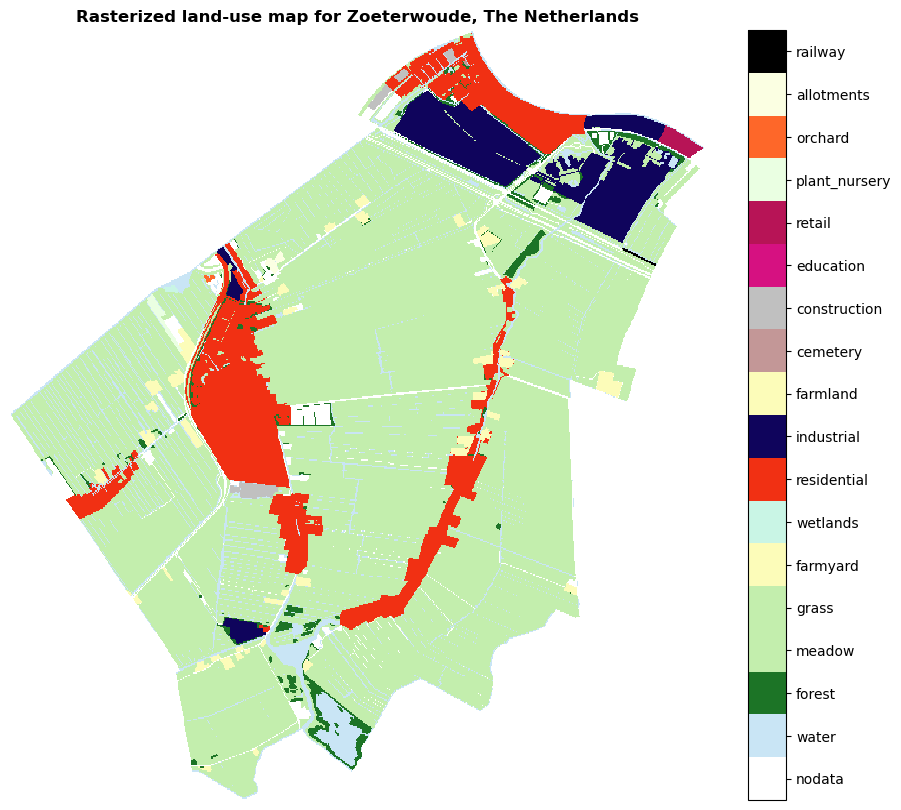

In [24]:
fig, ax = plt.subplots(1, 1,figsize=(14,10))

ax = landuse_valued["landuse_value"].plot(levels=len(unique_classes), cmap=cm, norm=norm)

# remove the ax labels
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2
cb = fig.colorbar(ax, format=fmt, ticks=tickz)

fig.axes[0].set_title('Rasterized land-use map for {}'.format(place_name),fontweight='bold')

fig.axes[0].set_xticks([])
fig.axes[0].set_yticks([])
fig.axes[0].set_axis_off()

# for some weird reason we get two colorbars, so we remove one:
fig.delaxes(fig.axes[1])

## 4. Extracting buildings from OpenStreetMap
<hr>

There is a lot more data to extract from OpenStreetMap besides land-use information. Let's extract some building data. To do so, we use the *"building"* tag.

In [25]:
tags = {"building": True}
buildings = ox.geometries_from_place(place_name, tags)

Now let's see what information is actually extracted:

In [26]:
buildings.head()

geometry  \
element_type osmid                                                         
way          52968216  POLYGON ((4.49599 52.13072, 4.49573 52.13064, ...   
             52968227  POLYGON ((4.50314 52.11085, 4.50313 52.11076, ...   
             52968240  POLYGON ((4.54569 52.13750, 4.54569 52.13750, ...   
             52968314  POLYGON ((4.50091 52.12679, 4.50107 52.12683, ...   
             52968395  POLYGON ((4.54522 52.13753, 4.54522 52.13752, ...   

                                                                   nodes  \
element_type osmid                                                         
way          52968216  [2691959880, 2691959870, 671093032, 2691959869...   
             52968227  [671091914, 671092761, 671096721, 671088133, 6...   
             52968240  [671091706, 671092556, 671094945, 671088229, 6...   
             52968314  [671096802, 671092834, 671086901, 671094558, 6...   
             52968395  [671096899, 671086139, 671089497, 671096082, 6...   

                         building building:levels           ref:bag  \
element_type osmid                                                    
way          52968216         yes               2   638100000363767   
             52968227  industrial             NaN   638100000368391   
             52968240         yes             NaN               NaN   
             52968314    paviljon               1  0638100000365876   
             52968395         yes             NaN               NaN   

                             source source:date start_date     name  \
element_type osmid                                                    
way          52968216  3dShapes;BAG  2014-02-11       1998      NaN   
             52968227  3dShapes;BAG  2014-02-11       1958  Rustdam   
             52968240      3dShapes         NaN        NaN      NaN   
             52968314           BAG  2022-01-28       1984      NaN   
             52968395      3dShapes         NaN        NaN      NaN   

                           man_made  ... outdoor_seating location  \
element_type osmid                   ...                            
way          52968216           NaN  ...             NaN      NaN   
             52968227           NaN  ...             NaN      NaN   
             52968240  storage_tank  ...             NaN      NaN   
             52968314           NaN  ...             NaN      NaN   
             52968395  storage_tank  ...             NaN      NaN   

                      social_facility social_facility:for bridge:support  \
element_type osmid                                                         
way          52968216             NaN                 NaN            NaN   
             52968227             NaN                 NaN            NaN   
             52968240             NaN                 NaN            NaN   
             52968314             NaN                 NaN            NaN   
             52968395             NaN                 NaN            NaN   

                      building:colour min_height roof:colour ways type  
element_type osmid                                                      
way          52968216             NaN        NaN         NaN  NaN  NaN  
             52968227             NaN        NaN         NaN  NaN  NaN  
             52968240             NaN        NaN         NaN  NaN  NaN  
             52968314             NaN        NaN         NaN  NaN  NaN  
             52968395             NaN        NaN         NaN  NaN  NaN  

[5 rows x 49 columns]

As you notice in the output of the cell above, there are many columns which just contain "NaN". And there even seem to be to many columns to even visualize properly in one view.

Let's check what information is collected for the different buildings:

In [27]:
buildings.columns

Index(['geometry', 'nodes', 'building', 'building:levels', 'ref:bag', 'source',
       'source:date', 'start_date', 'name', 'man_made', 'amenity', 'addr:city',
       'addr:housenumber', 'addr:street', 'alt_name', 'denomination',
       'old_name:1896-2016', 'religion', 'wikidata', 'wikipedia', 'power',
       'leisure', 'sport', 'healthcare', 'shop', 'website', 'club',
       'addr:postcode', 'floating', 'roof:levels', 'roof:shape', 'note',
       'construction', 'layer', 'url', 'height', 'office', 'cuisine',
       'diet:vegetarian', 'outdoor_seating', 'location', 'social_facility',
       'social_facility:for', 'bridge:support', 'building:colour',
       'min_height', 'roof:colour', 'ways', 'type'],
      dtype='object')

## 5. Analyze and visualize building stock
<hr>

One interesting column is called `start_date`. This shows the building year per building. 

Let's explore this year of building a bit more.

First, it would be interesting to get an idea how many buildings are build in each year through using the `value_counts()` function. Normally, that functions ranks the values in descending order (high to low). We are more interested in how this has developed over time. So we use the `sort_index()` function to sort the values by year.

In [28]:
building_year = buildings.start_date.value_counts().sort_index()

There is not better way to further explore this years than through plotting it.

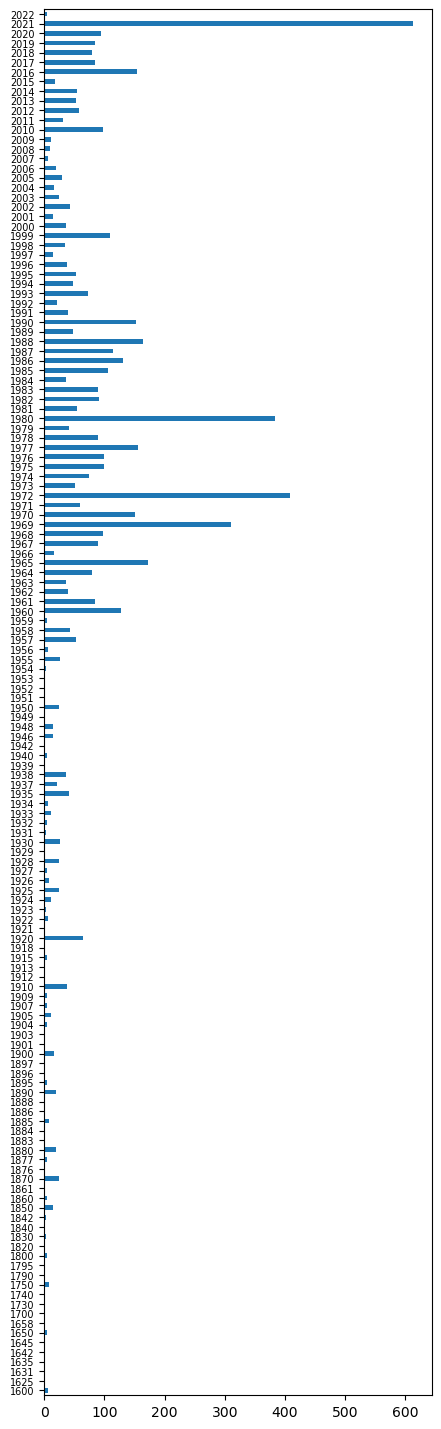

In [29]:
fig,ax = plt.subplots(1,1,figsize=(5,18))

building_year.plot(kind='barh',ax=ax)

ax.tick_params(axis='y', which='major', labelsize=7)

What we also noticed is that quite some buildings are identified as 'yes'. This is not very useful as it does not really say much about the use of the building. 

Let's see for how many buildings this is the case: 

In [30]:
buildings.building.value_counts().index

Index(['yes', 'house', 'industrial', 'apartments', 'shed', 'garage', 'retail',
       'construction', 'commercial', 'office', 'parking', 'houseboat',
       'greenhouse', 'static_caravan', 'barn', 'roof', 'farm_auxiliary',
       'pavilion', 'warehouse', 'farm', 'bungalow', 'church', 'paviljon',
       'service'],
      dtype='object')

Now let's visualize the buildings again. We need to create a similar color dictionary as we did for the land-use categories. Now its up to you to make it!

In [31]:
color_dict = { 'yes' : "#f1134b", 
              'house':'#f13013', 
              'industrial':'#0f045c',
              'apartments':'#781809', 
              'shed' : "#F89789", 
              'garage': "#F89789", 
              'retail':'#b71456',
               'construction':'#c0c0c0', 
              'commercial':'#CB8DDB', 
              'office': "#20b1bd", 
              'parking' : "#000000",
              'houseboat': "#F35942",
              'greenhouse': '#eaffe2', 
              'static_caravan': '#ff3a55',
              'barn':'#fcfcb9', 
              'roof':'#fcfcb9', 
              'farm_auxiliary':'#fcfcb9',
              'pavilion':'#CB8DDB', 
              'warehouse':'#CB8DDB', 
              'farm':'#fcfcb9', 
              'bungalow':'#f13013', 
              'church' : "#513857", 
              'paviljon':'#CB8DDB',
              'service':'#CB8DDB' }

In [32]:
# Remove multiple keys from dictionary
color_dict = {key: color_dict[key]
             for key in color_dict if key not in  list(set(color_dict)-set(buildings.building.unique()))}

map_dict = dict(zip(color_dict.keys(),[x for x in range(len(color_dict))]))
buildings['col_landuse'] =buildings.building.apply(lambda x: color_dict[x])

And plot the figure in the same manner!

Text(0.5, 1.0, 'Zoeterwoude, The Netherlands')

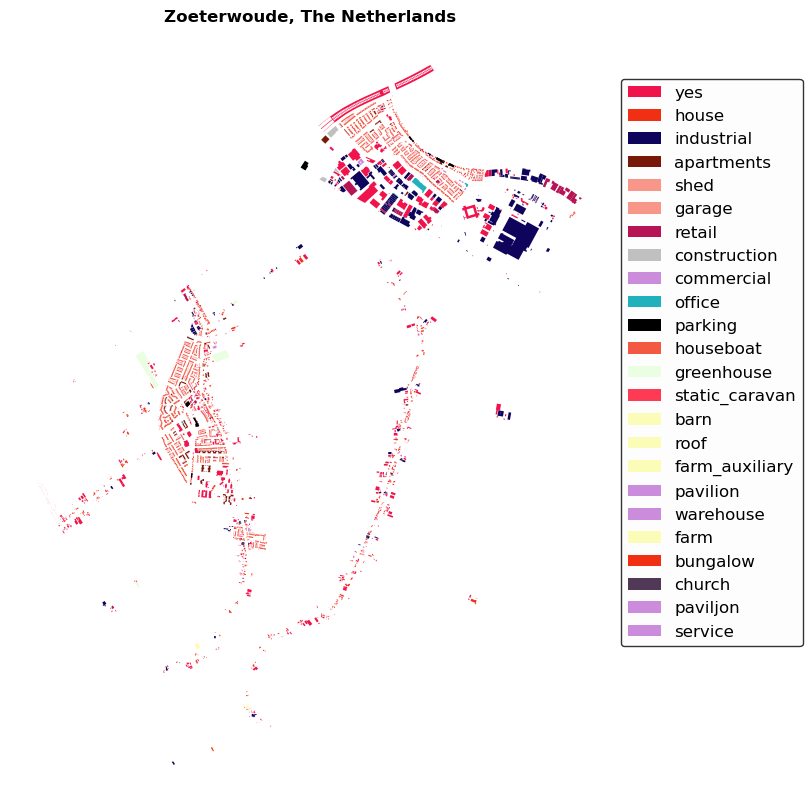

In [33]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))

# add color scheme
color_scheme_map = list(color_dict.values())
cmap = LinearSegmentedColormap.from_list(name='landuse',
                                     colors=color_scheme_map)  

# and plot the land-use map.
buildings.plot(color=buildings['col_landuse'],ax=ax,linewidth=0)

# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

# add a legend:
legend_elements = []
for iter_,item in enumerate(color_dict):
    legend_elements.append(Patch(facecolor=color_scheme_map[iter_],label=item))        

ax.legend(handles=legend_elements,edgecolor='black',facecolor='#fefdfd',prop={'size':12},loc=(1.02,0.2)) 

# add a title
ax.set_title(place_name,fontweight='bold')

## 6. Extracting roads from OpenStreetMap
<hr>

Let's continue (and end) this tutorial with the core data in OpenStreetMap (it is even in the name): roads!

Now, instead of using tags, we want to identify what type of roads we would like to extract. Let's first only extract roads that can be used to drive.

The `graph_from_place()` function returns a `NetworkX` Graph element. You can read more about these graph elements in the introduction page of [NetworkX](https://networkx.org/documentation/stable/reference/introduction.html).

In [34]:
G = ox.graph_from_place(place_name, network_type="drive")

Unfortunately, it is  bit difficult to easily view all the roads within such a Graph element. To be able to explore the data, we are going to convert it to a `Geopandas GeoDataFrame`, using the `to_pandas_edgelist()` function.

In [35]:
roads = gpd.GeoDataFrame(nx.to_pandas_edgelist(G))

C:\Users\eks510\.conda\envs\py310\lib\site-packages\pandas\core\dtypes\cast.py:122: ShapelyDeprecationWarning: The array interface is deprecated and will no longer work in Shapely 2.0. Convert the '.coords' to a numpy array instead.
  arr = construct_1d_object_array_from_listlike(values)


In some cases, roads are classified with more than one category. If that is the case, they are captured within a `list`. To overcome this issue, we specify that we want the entire `highway` column as a `string` dtype.

In [36]:
roads.highway = roads.highway.astype('str')

Now we can create a plot to see how the road network is configured.

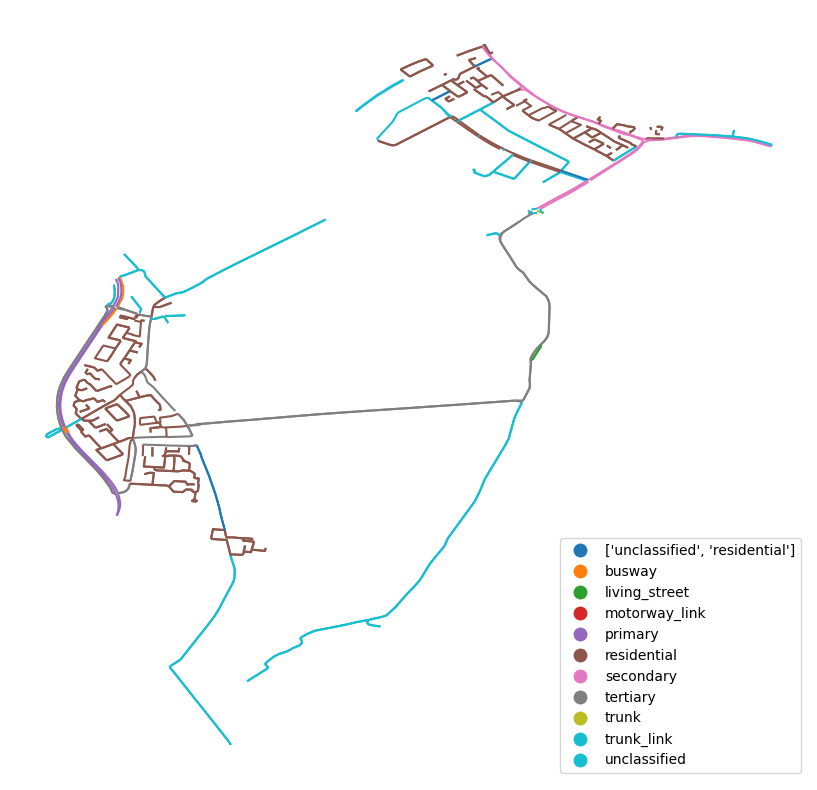

In [37]:
fig, ax = plt.subplots(1, 1,figsize=(12,10))


roads.plot(column='highway',legend=True,ax=ax,legend_kwds={'loc': 'lower right'});


# remove the ax labels
ax.set_xticks([])
ax.set_yticks([])
ax.set_axis_off()

It would also be interesting to explore the network a little but more interactively. **OSMnx** has a function called `plot_graph_folium()`, which allow us to use the [folium](https://python-visualization.github.io/folium/quickstart.html#Getting-Started) package to plot data interactively on a map. 

In [38]:
m1 = ox.plot_graph_folium(G, popup_attribute="highway", weight=2, color="#8b0000")
m1

## 7. Plot Routes Using OpenStreetMap and Folium
<hr>

One of the exiting things we can do with this data is that we can compute and plot routes between two points on a map.

Let's first select two random start and end points from the graph and compute the shortest route between them through using the `shortest_path()` function of the `NetworkX` package.

In [39]:
origin_node = ox.nearest_nodes(G,area['bbox_west'].values[0], area['bbox_north'].values[0])
destination_node = ox.nearest_nodes(G,area['bbox_east'].values[0], area['bbox_south'].values[0])
route = nx.shortest_path(G, origin_node, destination_node)

We can plot the route with folium. Like above, you can pass keyword args along to folium PolyLine to style the lines.

In [43]:
m2 = ox.plot_route_folium(G, route, weight=10)
m2

Plot the route with folium on top of the previously created map


In [41]:
m3 = ox.plot_route_folium(G, route, route_map=m1, popup_attribute="name", weight=7)
m3